In [41]:
#Main imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
rng = np.random.default_rng()

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def newfig(title=None, xlabel=None, ylabel=None, figsize=(10,10), legend=True, grid=True, equal=True):
    fig = plt.figure(figsize=figsize)
    plt.grid(grid)
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if equal:
        plt.axis("equal")
    # if legend:
        # plt.legend()
    return fig

def projfig(*args, title=None, xlabel=None, ylabel=None, figsize=(15,15), bins=100, legend=True, grid=True, equal=True):
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    for i, ax in enumerate([axs[0,0], axs[1,0], axs[0,1]]):
        for arg in args:
            if i:
                ax.hist(arg[0][i-1], bins=bins, label=arg[2], orientation=['vertical','horizontal'][i-1], histtype='step')
            else:
                ax.scatter(*arg[0], arg[1], label=arg[2])    

        ax.grid(grid)
        if title:
            ax.set_title(title+["", " y projection", " x projection"][i])
        if xlabel and i != 2:
            ax.set_xlabel(xlabel)
        if ylabel and i != 1:
            ax.set_ylabel(ylabel)
        # if equal and not i:
        #     ax.axis("equal")
        if legend:
            ax.legend()

    axs[1,1].set_axis_off()
    return fig, axs

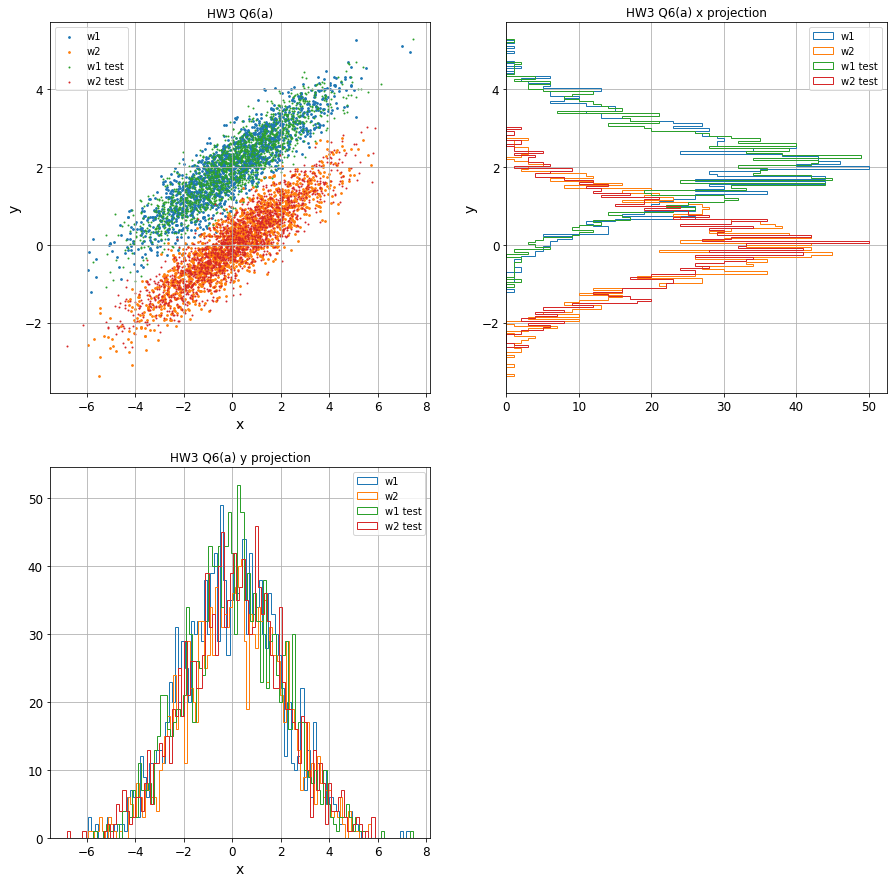

In [42]:
mu1, sig1 = np.array([0, 2]), np.array([[4, 1.8], [1.8, 1]])
mu2, sig2 = np.array([0, 0]), np.array([[4, 1.8], [1.8, 1]])

N = 1500
w1 = rng.multivariate_normal(mu1, sig1, N).T
w2 = rng.multivariate_normal(mu2, sig2, N).T
w1_test = rng.multivariate_normal(mu1, sig1, N).T
w2_test = rng.multivariate_normal(mu2, sig2, N).T

f, a = projfig((w1, 3, "w1"), (w2, 3, "w2"), (w1_test, 1, "w1 test"), (w2_test, 1, "w2 test"), title="HW3 Q6(a)", xlabel="x", ylabel="y")

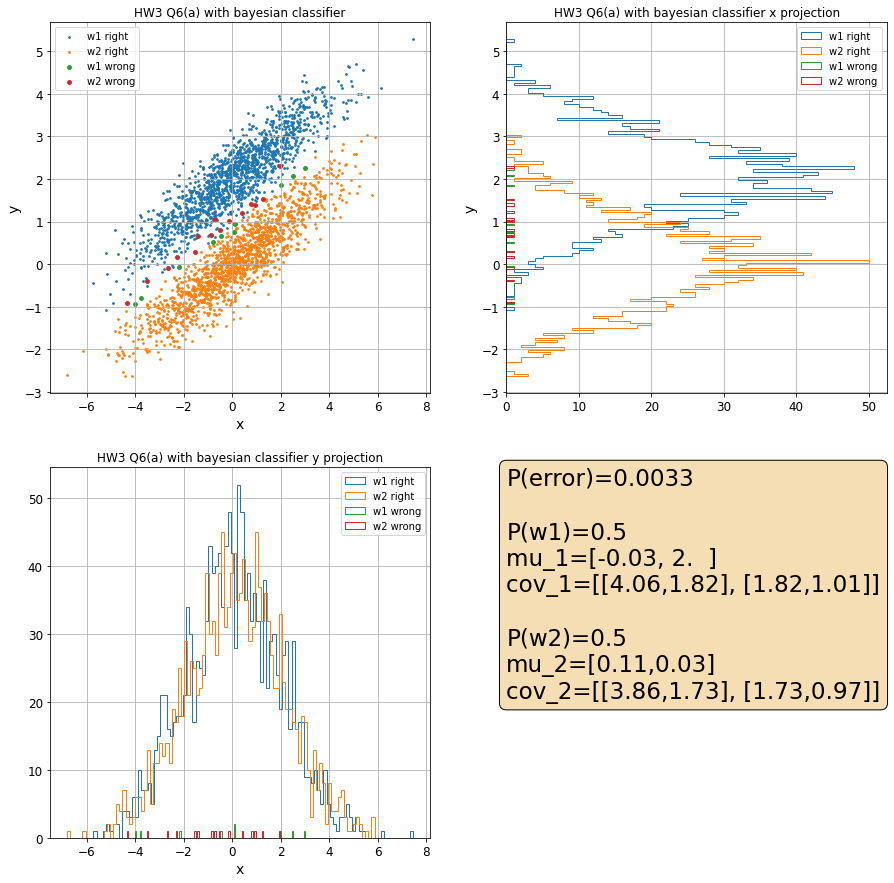

In [43]:
class bayes_clf():
    ''' bayesian classifier with option to choose naive bayes '''
    def __init__(self, method="bayes") -> None:
        self.method = method
        if method not in ["bayes", "naive"]:
            raise Exception(f"Method not valid! {type(self.method)}:'{self.method}'.")

        self.classes = {}
        self.risk = np.array([])

    def train(self, X, y) -> 'bayes_clf':
        ''' y must be of form [0, 1, ..., n]'''
        for c in np.unique(y):
            XX = X[y == c]
            prior = len(XX)/len(X)
            mu = np.mean(XX, axis=0)
            
            if self.method == "bayes":
                cov = np.cov(XX.T)
            elif self.method == "naive":
                cov = np.identity(XX.shape[1])*np.var(XX.T, axis=1)
            else:
                raise Exception(f"Method not valid! {type(self.method)}:'{self.method}'.")

            self.classes[c] = {"prior" : prior, "mean" : mu, "cov" : cov}

        k = len(self.classes)
        self.risk = np.r_[np.ones((1, k)), np.ones((k,k))-np.identity(k)]
        return self

    def predict(self, X) -> np.array:
        y = np.array([-1]*len(X))
        P = np.array([0]*len(self.classes))
        for i, xx in enumerate(X):
            for c, val in self.classes.items():
                pr, mu, cov = val["prior"], val["mean"], val["cov"]
                icov = np.linalg.inv(cov)
                g = -1/2 * ( np.matmul(np.matmul((xx - mu), icov), (xx - mu).T) - np.log(np.linalg.det(cov)) ) + np.log(pr)
                P[int(c)] = g
            
            y[i] = np.argmax(P)#np.matmul(self.risk, P))

        return y

clf = bayes_clf()
clf.train(np.r_[w1.T,w2.T], np.append(np.zeros((1,N)), np.ones((1,N))))

y1_pred = clf.predict(w1_test.T)
y2_pred = clf.predict(w2_test.T)

w1_as_w1 = w1_test.T[y1_pred == 0].T
w1_as_w2 = w1_test.T[y1_pred == 1].T
w2_as_w1 = w2_test.T[y2_pred == 0].T
w2_as_w2 = w2_test.T[y2_pred == 1].T

pe = (len(y1_pred[y1_pred==1])+len(y2_pred[y2_pred==2]))/(2*N)

f, a = projfig((w1_as_w1, 3, "w1 right"), (w2_as_w2, 3, "w2 right"), (w1_as_w2, 15, "w1 wrong"), \
    (w2_as_w1, 15, "w2 wrong"), title="HW3 Q6(a) with bayesian classifier", xlabel="x", ylabel="y")

# a[1,1].text(.5, .5, f"{clf.classes} P_e={pe}", verticalalignment="center", horizontalalignment="center")

textstr = '\n'.join((
    f'P(error)={pe:.4f}',
    '','P(w1)='+str(clf.classes[0]["prior"]),
    'mu_1='+np.array2string(clf.classes[0]["mean"], precision=2, separator=',',suppress_small=True),
    'cov_1='+np.array2string(clf.classes[0]["cov"], precision=2, separator=',',suppress_small=True).replace('\n',''),
    '','P(w2)='+str(clf.classes[1]["prior"]),
    'mu_2='+np.array2string(clf.classes[1]["mean"], precision=2, separator=',',suppress_small=True),
    'cov_2='+np.array2string(clf.classes[1]["cov"], precision=2, separator=',',suppress_small=True).replace('\n','')))#,

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

# place a text box in upper left in axes coords
a[1,1].text(0, 1, textstr, transform=a[1,1].transAxes, fontsize=23,
        verticalalignment='top', bbox=props);


X= [[-1.24435945  2.92507171  0.48242291 ...  2.43520817 -1.34896508
   0.42644114]
 [ 1.90261976  3.3215988   2.69450692 ...  0.52553529 -0.36969235
   0.82980544]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
y= [0. 0. 0. ... 1. 1. 1.]


array([[  5.43801704],
       [-11.53085944],
       [ 11.42121235]])

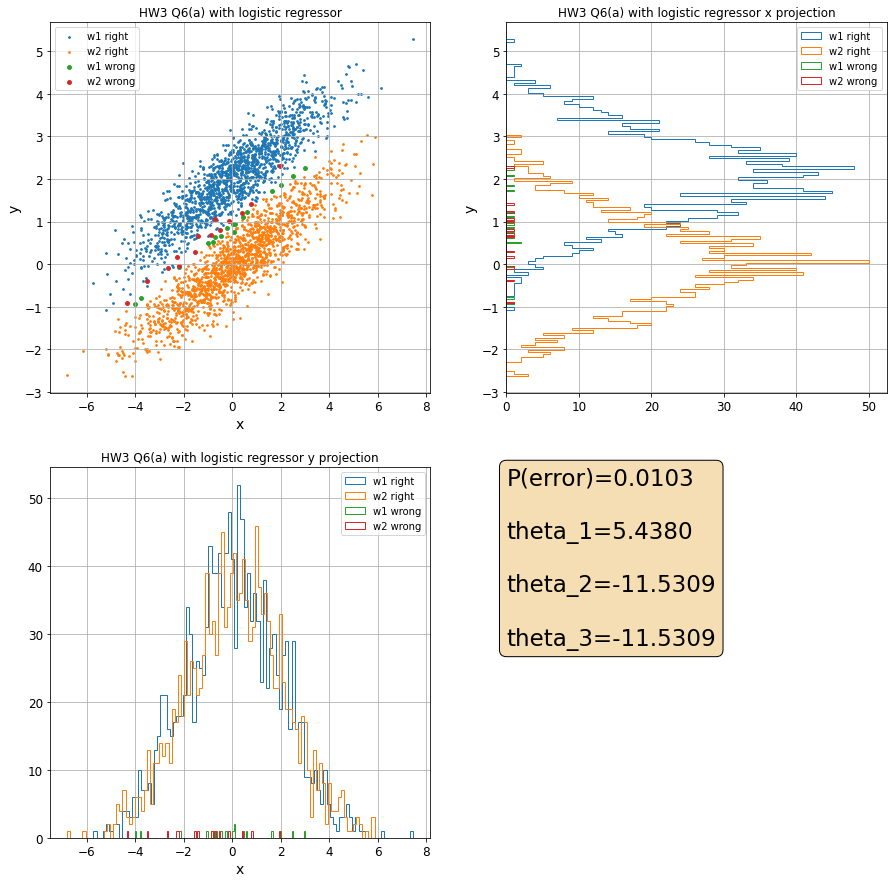

In [44]:
class logistic_reg():
    ''' logistic regression with gradient descent '''
    def __init__(self, rho=0.001, tol=10e-4, max_iter=10000) -> None:
        self.rho = rho
        self.max_iter = max_iter
        self.tol = tol
        self.theta = np.array([])
    def train(self, X, y) -> 'logistic_reg':
        X = np.hstack((X, np.array([1]*len(X)).reshape(-1,1))).T
        print("X=",X)
        print("y=",y)
        self.theta = np.array([-2., -1, 1]).reshape(-1,1)#np.random.rand(X.shape[1])
        for i in range(self.max_iter):
            
            theta_prev = self.theta
            s = 1/(1+np.exp(np.matmul(-self.theta.T, X)))
            self.theta = self.theta - self.rho * np.matmul( X, (s - y).T)
            if np.sum(np.abs(self.theta-theta_prev)) < self.tol:
                return self

            # break
                
        print("Max iterations reached. Ending before tolerance reached.")
        return self

    def predict(self, X) -> np.array:
        X = np.hstack((X, np.array([1]*len(X)).reshape(-1,1))).T
        y = 1/(1+np.exp(np.matmul(-self.theta.T, X)))
        return y[0]

reg = logistic_reg()
reg.train(np.r_[w1.T,w2.T], np.append(np.zeros((1,N)), np.ones((1,N))))

y1_pred = reg.predict(w1_test.T)
y2_pred = reg.predict(w2_test.T)

w1_as_w1 = w1_test.T[y1_pred < 0.5].T
w1_as_w2 = w1_test.T[y1_pred > 0.5].T
w2_as_w1 = w2_test.T[y2_pred < 0.5].T
w2_as_w2 = w2_test.T[y2_pred > 0.5].T

pe = (len(y1_pred[y1_pred > 0.5])+len(y2_pred[y2_pred < 0.5]))/(2*N)

f, a = projfig((w1_as_w1, 3, "w1 right"), (w2_as_w2, 3, "w2 right"), (w1_as_w2, 15, "w1 wrong"), \
    (w2_as_w1, 15, "w2 wrong"), title="HW3 Q6(a) with logistic regressor", xlabel="x", ylabel="y")

# a[1,1].text(.5, .5, f"{clf.classes} P_e={pe}", verticalalignment="center", horizontalalignment="center")

textstr = '\n'.join((
    f'P(error)={pe:.4f}',
    '',f'theta_1={reg.theta[0,0]:.4f}',
    '',f'theta_2={reg.theta[1,0]:.4f}',
    '',f'theta_3={reg.theta[1,0]:.4f}'))

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

# place a text box in upper left in axes coords
a[1,1].text(0, 1, textstr, transform=a[1,1].transAxes, fontsize=23,
        verticalalignment='top', bbox=props);

reg.theta

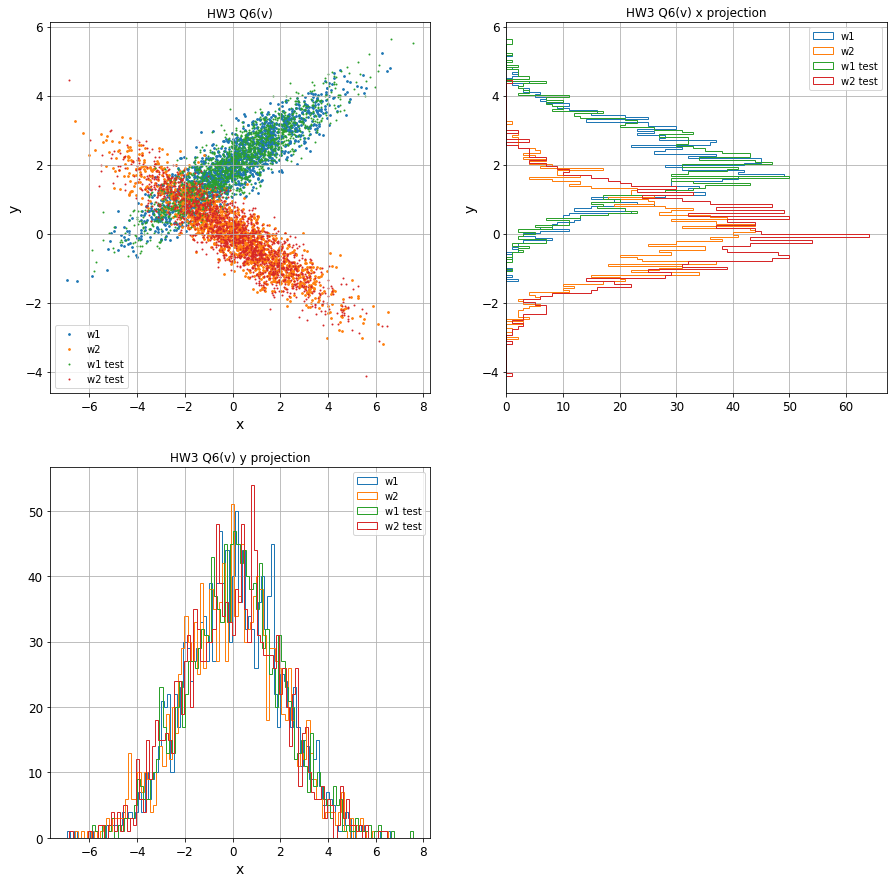

In [45]:
mu1, sig1 = np.array([0, 2]), np.array([[4, 1.8], [1.8, 1]])
mu2, sig2 = np.array([0, 0]), np.array([[4, -1.8], [-1.8, 1]])

N = 1500
w1 = rng.multivariate_normal(mu1, sig1, N).T
w2 = rng.multivariate_normal(mu2, sig2, N).T
w1_test = rng.multivariate_normal(mu1, sig1, N).T
w2_test = rng.multivariate_normal(mu2, sig2, N).T

f, a = projfig((w1, 3, "w1"), (w2, 3, "w2"), (w1_test, 1, "w1 test"), (w2_test, 1, "w2 test"), title="HW3 Q6(v)", xlabel="x", ylabel="y")

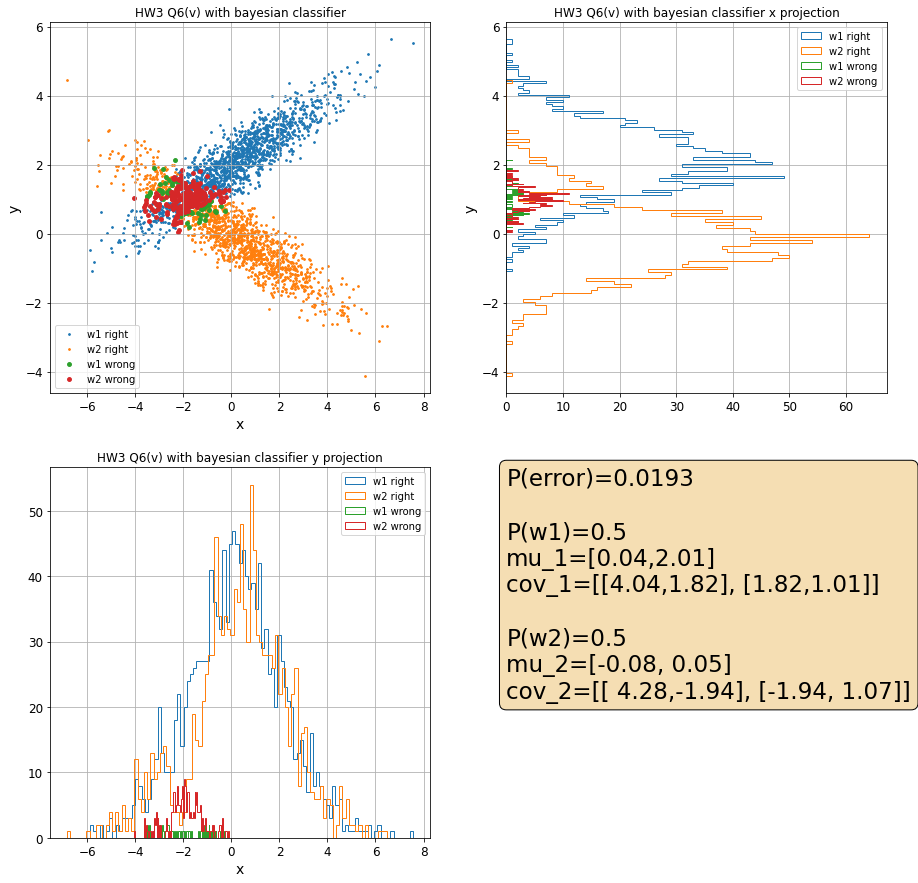

In [46]:
class bayes_clf():
    ''' bayesian classifier with option to choose naive bayes '''
    def __init__(self, method="bayes") -> None:
        self.method = method
        if method not in ["bayes", "naive"]:
            raise Exception(f"Method not valid! {type(self.method)}:'{self.method}'.")

        self.classes = {}
        self.risk = np.array([])

    def train(self, X, y) -> 'bayes_clf':
        ''' y must be of form [0, 1, ..., n]'''
        for c in np.unique(y):
            XX = X[y == c]
            prior = len(XX)/len(X)
            mu = np.mean(XX, axis=0)
            
            if self.method == "bayes":
                cov = np.cov(XX.T)
            elif self.method == "naive":
                cov = np.identity(XX.shape[1])*np.var(XX.T, axis=1)
            else:
                raise Exception(f"Method not valid! {type(self.method)}:'{self.method}'.")

            self.classes[c] = {"prior" : prior, "mean" : mu, "cov" : cov}

        k = len(self.classes)
        self.risk = np.r_[np.ones((1, k)), np.ones((k,k))-np.identity(k)]
        return self

    def predict(self, X) -> np.array:
        y = np.array([-1]*len(X))
        P = np.array([0]*len(self.classes))
        for i, xx in enumerate(X):
            for c, val in self.classes.items():
                pr, mu, cov = val["prior"], val["mean"], val["cov"]
                icov = np.linalg.inv(cov)
                g = -1/2 * ( np.matmul(np.matmul((xx - mu), icov), (xx - mu).T) - np.log(np.linalg.det(cov)) ) + np.log(pr)
                P[int(c)] = g
            
            y[i] = np.argmax(P)#np.matmul(self.risk, P))

        return y

clf = bayes_clf()
clf.train(np.r_[w1.T,w2.T], np.append(np.zeros((1,N)), np.ones((1,N))))

y1_pred = clf.predict(w1_test.T)
y2_pred = clf.predict(w2_test.T)

w1_as_w1 = w1_test.T[y1_pred == 0].T
w1_as_w2 = w1_test.T[y1_pred == 1].T
w2_as_w1 = w2_test.T[y2_pred == 0].T
w2_as_w2 = w2_test.T[y2_pred == 1].T

pe = (len(y1_pred[y1_pred==1])+len(y2_pred[y2_pred==2]))/(2*N)

f, a = projfig((w1_as_w1, 3, "w1 right"), (w2_as_w2, 3, "w2 right"), (w1_as_w2, 15, "w1 wrong"), \
    (w2_as_w1, 15, "w2 wrong"), title="HW3 Q6(v) with bayesian classifier", xlabel="x", ylabel="y")

# a[1,1].text(.5, .5, f"{clf.classes} P_e={pe}", verticalalignment="center", horizontalalignment="center")

textstr = '\n'.join((
    f'P(error)={pe:.4f}',
    '','P(w1)='+str(clf.classes[0]["prior"]),
    'mu_1='+np.array2string(clf.classes[0]["mean"], precision=2, separator=',',suppress_small=True),
    'cov_1='+np.array2string(clf.classes[0]["cov"], precision=2, separator=',',suppress_small=True).replace('\n',''),
    '','P(w2)='+str(clf.classes[1]["prior"]),
    'mu_2='+np.array2string(clf.classes[1]["mean"], precision=2, separator=',',suppress_small=True),
    'cov_2='+np.array2string(clf.classes[1]["cov"], precision=2, separator=',',suppress_small=True).replace('\n','')))#,

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

# place a text box in upper left in axes coords
a[1,1].text(0, 1, textstr, transform=a[1,1].transAxes, fontsize=23,
        verticalalignment='top', bbox=props);


X= [[-2.10733994 -1.30061606 -0.45051591 ... -1.77083205  0.68335432
  -5.06285775]
 [ 1.14055884  1.14325062  2.07873154 ...  1.76914636 -0.45150649
   2.68420607]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
y= [0. 0. 0. ... 1. 1. 1.]


array([[-0.10888099],
       [-1.86453637],
       [ 1.81687703]])

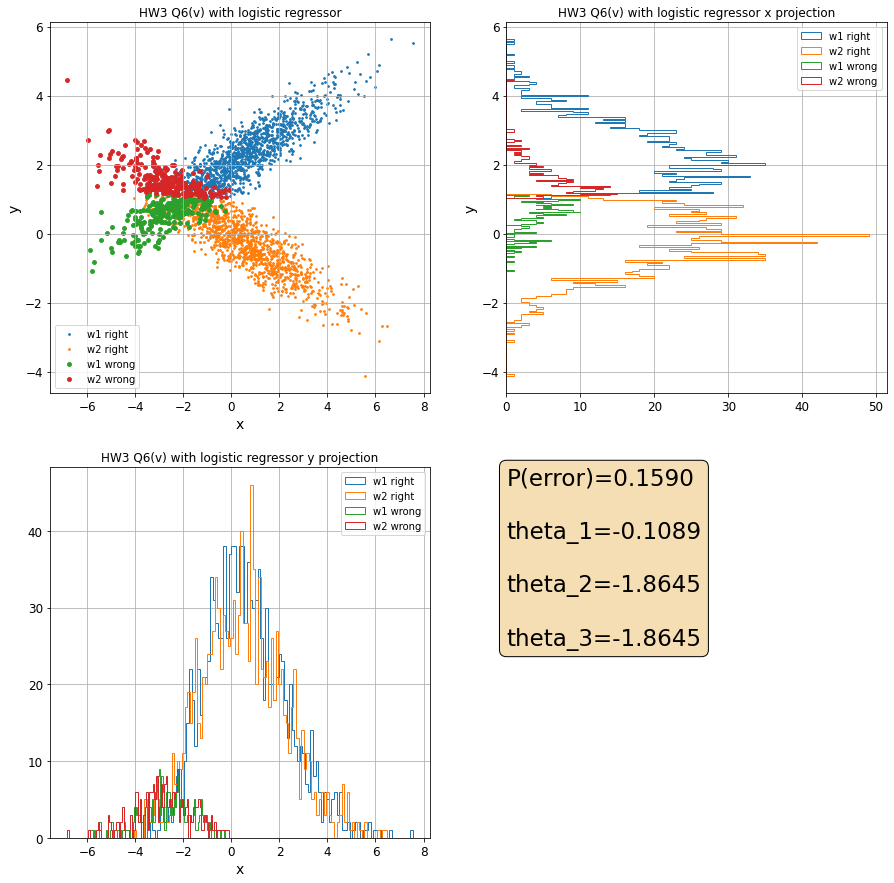

In [47]:
class logistic_reg():
    ''' logistic regression with gradient descent '''
    def __init__(self, rho=0.001, tol=10e-4, max_iter=10000) -> None:
        self.rho = rho
        self.max_iter = max_iter
        self.tol = tol
        self.theta = np.array([])
    def train(self, X, y) -> 'logistic_reg':
        X = np.hstack((X, np.array([1]*len(X)).reshape(-1,1))).T
        print("X=",X)
        print("y=",y)
        self.theta = np.array([-2., -1, 1]).reshape(-1,1)#np.random.rand(X.shape[1])
        for i in range(self.max_iter):
            
            theta_prev = self.theta
            s = 1/(1+np.exp(np.matmul(-self.theta.T, X)))
            self.theta = self.theta - self.rho * np.matmul( X, (s - y).T)
            if np.sum(np.abs(self.theta-theta_prev)) < self.tol:
                return self

            # break
                
        print("Max iterations reached. Ending before tolerance reached.")
        return self

    def predict(self, X) -> np.array:
        X = np.hstack((X, np.array([1]*len(X)).reshape(-1,1))).T
        y = 1/(1+np.exp(np.matmul(-self.theta.T, X)))
        return y[0]

reg = logistic_reg()
reg.train(np.r_[w1.T,w2.T], np.append(np.zeros((1,N)), np.ones((1,N))))

y1_pred = reg.predict(w1_test.T)
y2_pred = reg.predict(w2_test.T)

w1_as_w1 = w1_test.T[y1_pred < 0.5].T
w1_as_w2 = w1_test.T[y1_pred > 0.5].T
w2_as_w1 = w2_test.T[y2_pred < 0.5].T
w2_as_w2 = w2_test.T[y2_pred > 0.5].T

pe = (len(y1_pred[y1_pred > 0.5])+len(y2_pred[y2_pred < 0.5]))/(2*N)

f, a = projfig((w1_as_w1, 3, "w1 right"), (w2_as_w2, 3, "w2 right"), (w1_as_w2, 15, "w1 wrong"), \
    (w2_as_w1, 15, "w2 wrong"), title="HW3 Q6(v) with logistic regressor", xlabel="x", ylabel="y")

# a[1,1].text(.5, .5, f"{clf.classes} P_e={pe}", verticalalignment="center", horizontalalignment="center")

textstr = '\n'.join((
    f'P(error)={pe:.4f}',
    '',f'theta_1={reg.theta[0,0]:.4f}',
    '',f'theta_2={reg.theta[1,0]:.4f}',
    '',f'theta_3={reg.theta[1,0]:.4f}'))

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

# place a text box in upper left in axes coords
a[1,1].text(0, 1, textstr, transform=a[1,1].transAxes, fontsize=23,
        verticalalignment='top', bbox=props);

reg.theta